# Introdução

Nesse notebook temos a análise descritiva dos dados. O objetivo dessa análise será obtermos hipóteses sobre o comportamento dos dados que nos ajudem a construir os modelos para a previsão das remessas para cada um dos clusters.

Primeiro iremos carregar e validar os dados para em seguida realizar.

# Imports

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# Carregamento e análise preliminar dos dados

Para evitar o "vazamento" de informação dos dados de teste para a modelagem não iremos analisar os dados de teste. Essa é uma boa prática em modelagens supervisionadas e ajuda a garantir que quando estivermos aplicando o modelo aos dados de teste, estejamos em mais propício possível para testar a capacidade de generalização do modelo. Apensa consideraremos para a análise descritiva os dados de treinamento, localizados na planilha `Dados Históricos` do arquivo Excel. Ainda, para simplificar a análise, as variáveis de volume e dropsize serão desconsideradas. Dessa forma, iremos utilizar apenas as coluns `DataEntrega`, `Cluster`, e `Remessas`.

Junto aos dados originais, também é adicionada uma nova coluna indicando se o dia é um feriado. Os dados dos feriados são resgatados da planinha `Feriados Nacionais` de mesmo arquivo excel.

In [2]:
# carregando os dados de treinamento do arquivo excel
# para simplificar a análise iremos utilizar apenas a variável remessa
# a variável volume será descartada, e dropsize consequentemente 
# dropsize não agrega nenhuma informação nova uma vez que ela
# é a razão entre volume e remessas
df = pd.read_excel("Case.xlsx",
                   sheet_name="Dados Históricos",
                   usecols=["DataEntrega", "Cluster", "Remessas"])
# informacações gerais sobre o dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DataEntrega  3360 non-null   datetime64[ns]
 1   Cluster      3360 non-null   object        
 2   Remessas     3360 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 78.9+ KB


In [3]:
# olhando os primeiros registros
df.head()

,DataEntrega,Cluster,Remessas
0,2019-10-01,A,466
1,2019-10-01,B,5
2,2019-10-01,C,898
3,2019-10-01,D,159
4,2019-10-01,E,441


In [4]:
# carregando os dados de feriados para uma lista contendo apenas as datas
holiday_list = (pd.read_excel("Case.xlsx",
                              sheet_name="Feriados Nacionais",
                              usecols=["Datas"]).
                squeeze().to_list())
len(holiday_list)

14

Ao todo temos 14 dias que são feriados

In [5]:
# criando uma coluna no dataframe que indica se
# a data é referente a um feriado ou não
df["Feriado"] = df["DataEntrega"].isin(holiday_list)
# quantidade de dadas que são feriadas
df.loc[df["Feriado"], "DataEntrega"].nunique()

8

Dos 14 dias que são feriados apenas 8 estão na séria temporal

## Verificando os dados

Duas coisas precisam ser verificadas antes de seguirmos com a análise. A primeira, é a periodicidade dos dados. Isto é se os dados são diários, semanais ou mensais, e ainda, se para todos os diais referentes a data está compreendida nos dados. Em segundo lugar, se para todas as datas, todos os clusters possuem informações de remessas (mesmo se essa informação for 0).

In [16]:
# verificando se existem combinações duplicadas de
# datas e clusters
assert ~df[["DataEntrega", "Cluster"]].duplicated().any()

In [17]:
# identificando datas e quantos únicos
df[["DataEntrega", "Cluster"]].nunique()

DataEntrega    336
Cluster         10
dtype: int64

In [18]:
# verificando se temos a mesma exata quantidade de registro para cada cluster
assert (df["Cluster"].value_counts() == df["DataEntrega"].nunique()).all()

In [19]:
# identificando o começo e o fim do período
df["DataEntrega"].agg(["min", "max"]) 

min   2019-10-01
max   2020-08-31
Name: DataEntrega, dtype: datetime64[ns]

In [20]:
# identificando quais são os clusters únicos
df["Cluster"].unique()

array(['A', 'B', 'C', 'D', 'E', 'F', 'J', 'K', 'L', 'M'], dtype=object)

In [21]:
# identificando a periodicidade nos dados
df["DataEntrega"].drop_duplicates().sort_values().diff(1).dropna().value_counts()

1 days    335
Name: DataEntrega, dtype: int64

In [11]:
# verificando se a periodicidade diária é válida para todos os clusters
for cluster in df["Cluster"].unique():
    assert (df.loc[df["Cluster"] == cluster, "DataEntrega"].
            sort_values().diff(1).dropna() == pd.Timedelta(1, unit="days")).all()

Como é possível observar temos dados de remessas para 10 clusters distintos, de A a M, em 336 dias, de 01-10-2019 ao dia 31-08-2020. A frequência dos dados é diária, sendo preenchida diariamente para todos os clusters.

# Distribuição das remessas

Para avaliar a distribuição dos dados primeiro vamos analisá-la em termos desagregados e em seguida vamos a desagregando para entender melhor como os padrões nos dados podem estar sendo formados. Conforme a análise for se desenrolando novas desagregações, ou agregações, vão sendo identificadas como relevantes e serão utilizadas nessa análise descritiva dos dados de remessas.

Primeiro analisando o histograma da distribuição de remessas é possível observar que uma grande quantidade de observações possui nenhuma ou quantidade de remessas próxima a zero. Adicionalmente, temos pequena parcela dos dados contendo mais de 1000 remessas. Pela análise visual, é bastante clara a existência de assimetria à esquerda, de modo que é esperado que a mediana seja inferior à média.

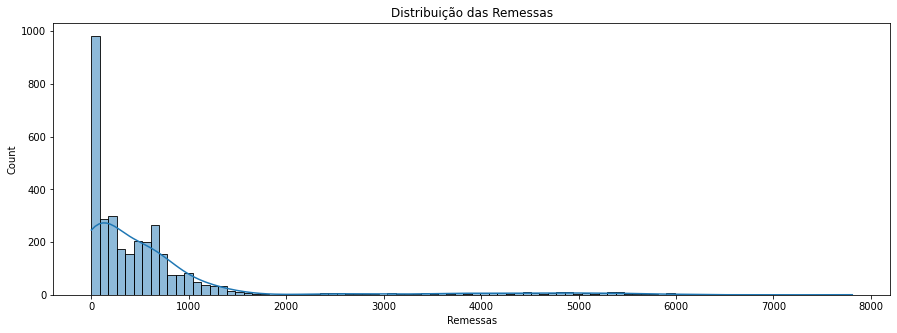

In [12]:
# analisando a distribuição das remessas com um histograma
plt.figure(figsize=(15, 5))
sns.histplot(data=df, x="Remessas", bins=90, kde=True)
plt.title("Distribuição das Remessas")
plt.show()

Pela análise da evolução temporal, vemos que boa parte da exitência de ocorrência de dias sem remessas pode ser explicado pela sazonalidade contida nos dados. A sazonalidade está representada pelas variações cíclicas nos dados quando estamos analisando-os a uma periodicidade diária. Ou seja, devemos ter alguns dias em que é mais comum que não ocorram nenhuma remessa.

Pela análise visual do gráfico, principalmente, das médias semanais e mensais, aparentemente não há uma tendência clara e a variância parece ser mais ou menos constante. O que indica, que, a princípio, essa série temporal é estacionária. Porém, testes estatísticos mais eficazes precisam ser realizados para validarmos essa hipótese.

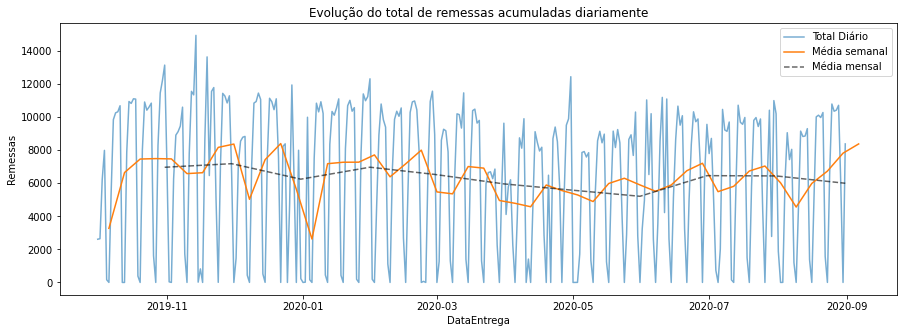

In [25]:
plt.figure(figsize=(15,5))
sns.lineplot(data=(df.groupby("DataEntrega")["Remessas"].
                   sum()),
             alpha=0.6);
sns.lineplot(data=(df.groupby("DataEntrega")["Remessas"].
                   sum().resample("W").mean()))
sns.lineplot(data=(df.groupby("DataEntrega")["Remessas"].
                   sum().resample("M").mean()),
             color="black", linestyle="--", alpha=0.6);
plt.legend(["Total Diário", "Média semanal", "Média mensal"])
plt.title("Evolução do total de remessas acumuladas diariamente")
plt.show()

## Análise por dia da Semana

Como hipótese preliminar, vamos trabalhar com uma sazonalidade semanal. Ou seja, a variação dos dados de remessas segue um padrão cíclico que se repete a cada semana. Dessa forma, devemos analisar cada dia da semana em separado para analisar como é a sua distribuição.

Pelo boxplot da distribuição diária de remessas temos fortes indícios para crer que a sazonalidade da série temporal de remessas é semanal. Adicionalmente, nos finais de semana concentram-se a maior parte dos dias sem remessas. Para todos os dias da semana vemos que a distribuição possui uma assimetria para a direita, de modo que é esperado que a média seja superior à mediana.

In [26]:
# criando uma nova variável do dia da semana da data
# os rótulos dessa variável são em inglês
df["DiaNome"] = df["DataEntrega"].dt.day_name()

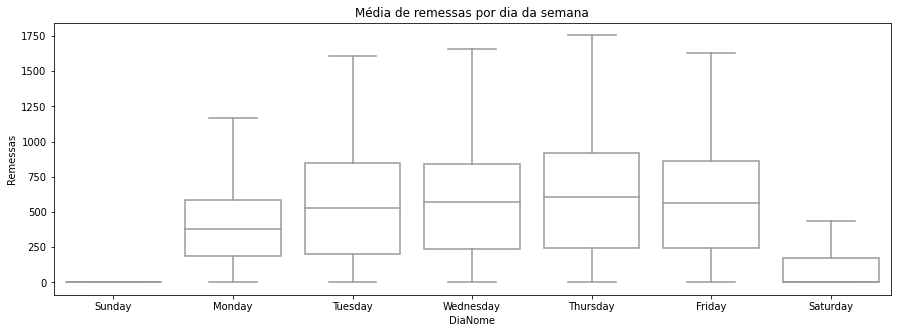

In [47]:
# definindo a ordem do eixo x
week_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
# gerando o boxplot
plt.figure(figsize=(15,5))
sns.boxplot(x="DiaNome", y="Remessas", data=df, order=week_order, showfliers=False, color="white")
#df.boxplot(column="Remessas", by="DiaNome", title="")
# rotacionando os rótulos dos ticks do eixo x
plt.xticks(rotation=0)
# atribuindo título ao eixo y
plt.ylabel("Remessas")
# atribuindo título à figura
plt.title("Média de remessas por dia da semana")
plt.show()

Quando analisamos a distribuição das remessas por dia útil, vemos que os Feriados possuem comportamento similar aos de final de semana (especialmente domingo). Com isso podemos generalizar essa suposição e segmentar a análise entre dia útil e não útil.

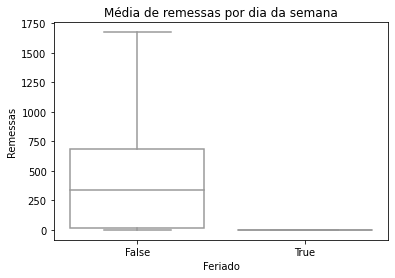

In [49]:
sns.boxplot(x="Feriado", y="Remessas", data=df, showfliers=False, color="white")
# rotacionando os rótulos dos ticks do eixo x
plt.xticks(rotation=0)
# atribuindo título ao eixo y
plt.ylabel("Remessas")
# atribuindo título à figura
plt.title("Média de remessas por dia da semana")
plt.show()

In [71]:
weekend_mask = df["DiaNome"].isin(["Saturday", "Sunday"])
df["DiaComercial"] = ~(weekend_mask | df["Feriado"])

In [73]:
df.groupby("DiaComercial")["Remessas"].describe().round(2).T

DiaComercial,False,True
count,1020.00,2340.00
mean,113.39,858.32
std,438.14,1193.77
min,0.00,0.00
25%,0.00,233.50
50%,0.00,533.00
75%,1.00,801.25
max,4838.00,7810.00


Analisando a tabela de contigência entre dias cuja quantidade de remessas é igual a zero e dias comerciais, vemos que apenas 3,5% dos dias comerciais não possuíram remessas. Em contrapartida, dos dias não comerciais, 72,45% não tiveram remessas. Ou seja, tudo indica que o fato do dia ser comercial ou não é um forte determinante para termos ou não remessa.

In [24]:
cross_ship_comerc = pd.crosstab((df["Remessas"] == 0).rename("SemRemessas"),
                                df["DiaComercial"])
cross_ship_comerc.div(cross_ship_comerc.sum()).mul(100).round(2)

DiaComercial,False,True
SemRemessas,,
False,27.55,96.5
True,72.45,3.5


## Análise por Cluster

Agora vamos fazer a análise segmentando os dados por cluster. Em seguida vamos juntar as duas segmentações para completar essa análise mais geral das distribuições dos dados de remessas.

A distribuição entre os clusters é bastante desigual, o cluster F concentra quase a metade de todas as remessas. Em segundo lugar, temos o cluster E com 12%. O cluster L é aquele que possui a menor parcela de remessas, apenas 1,7%. O restante varia entre 2% a 9%.

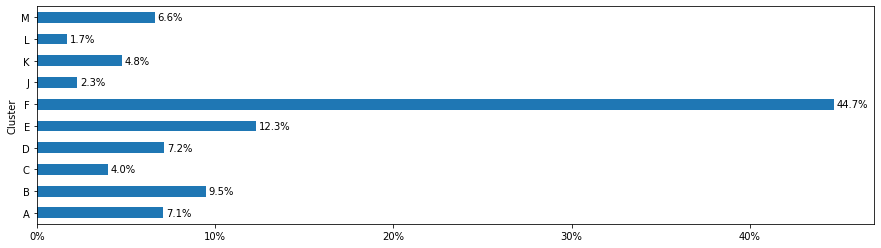

In [150]:
ax = df.groupby("Cluster")["Remessas"].sum().div(df["Remessas"].sum()).plot(kind="barh", figsize=(15, 4))
ax.bar_label(ax.containers[0],
             labels=[f"{x.get_width():.1%}" for x in ax.containers[0]],
             padding=3)

ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}')) 
plt.show()

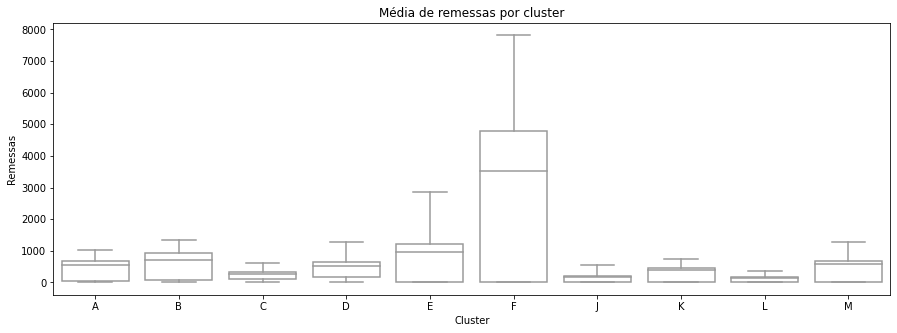

In [78]:
# gerando o boxplot
plt.figure(figsize=(15,5))
sns.boxplot(x="Cluster", y="Remessas", data=df, showfliers=False, color="white")
# rotacionando os rótulos dos ticks do eixo x
plt.xticks(rotation=0)
# atribuindo título ao eixo y
plt.ylabel("Remessas")
# atribuindo título à figura
plt.title("Média de remessas por cluster")
plt.show()

Cruzando os dados de cluster com os dias de semana para avaliar a distribuição dos dados por essas combinações, vemos que o fator mais importante para determinar a forma da distribuição são os dias de semana. Não que o cluster não seja importante, mas essa informação está mais associada com a escala da quantidade de remessas do que os aspectos estruturais da distribuição. É importante ter em mente que o gráfico a baixo os diversos histogramas em grid não compartilham o eixo X e Y, de modo que devem ser utilizados mais para comparar a forma das distribuições.

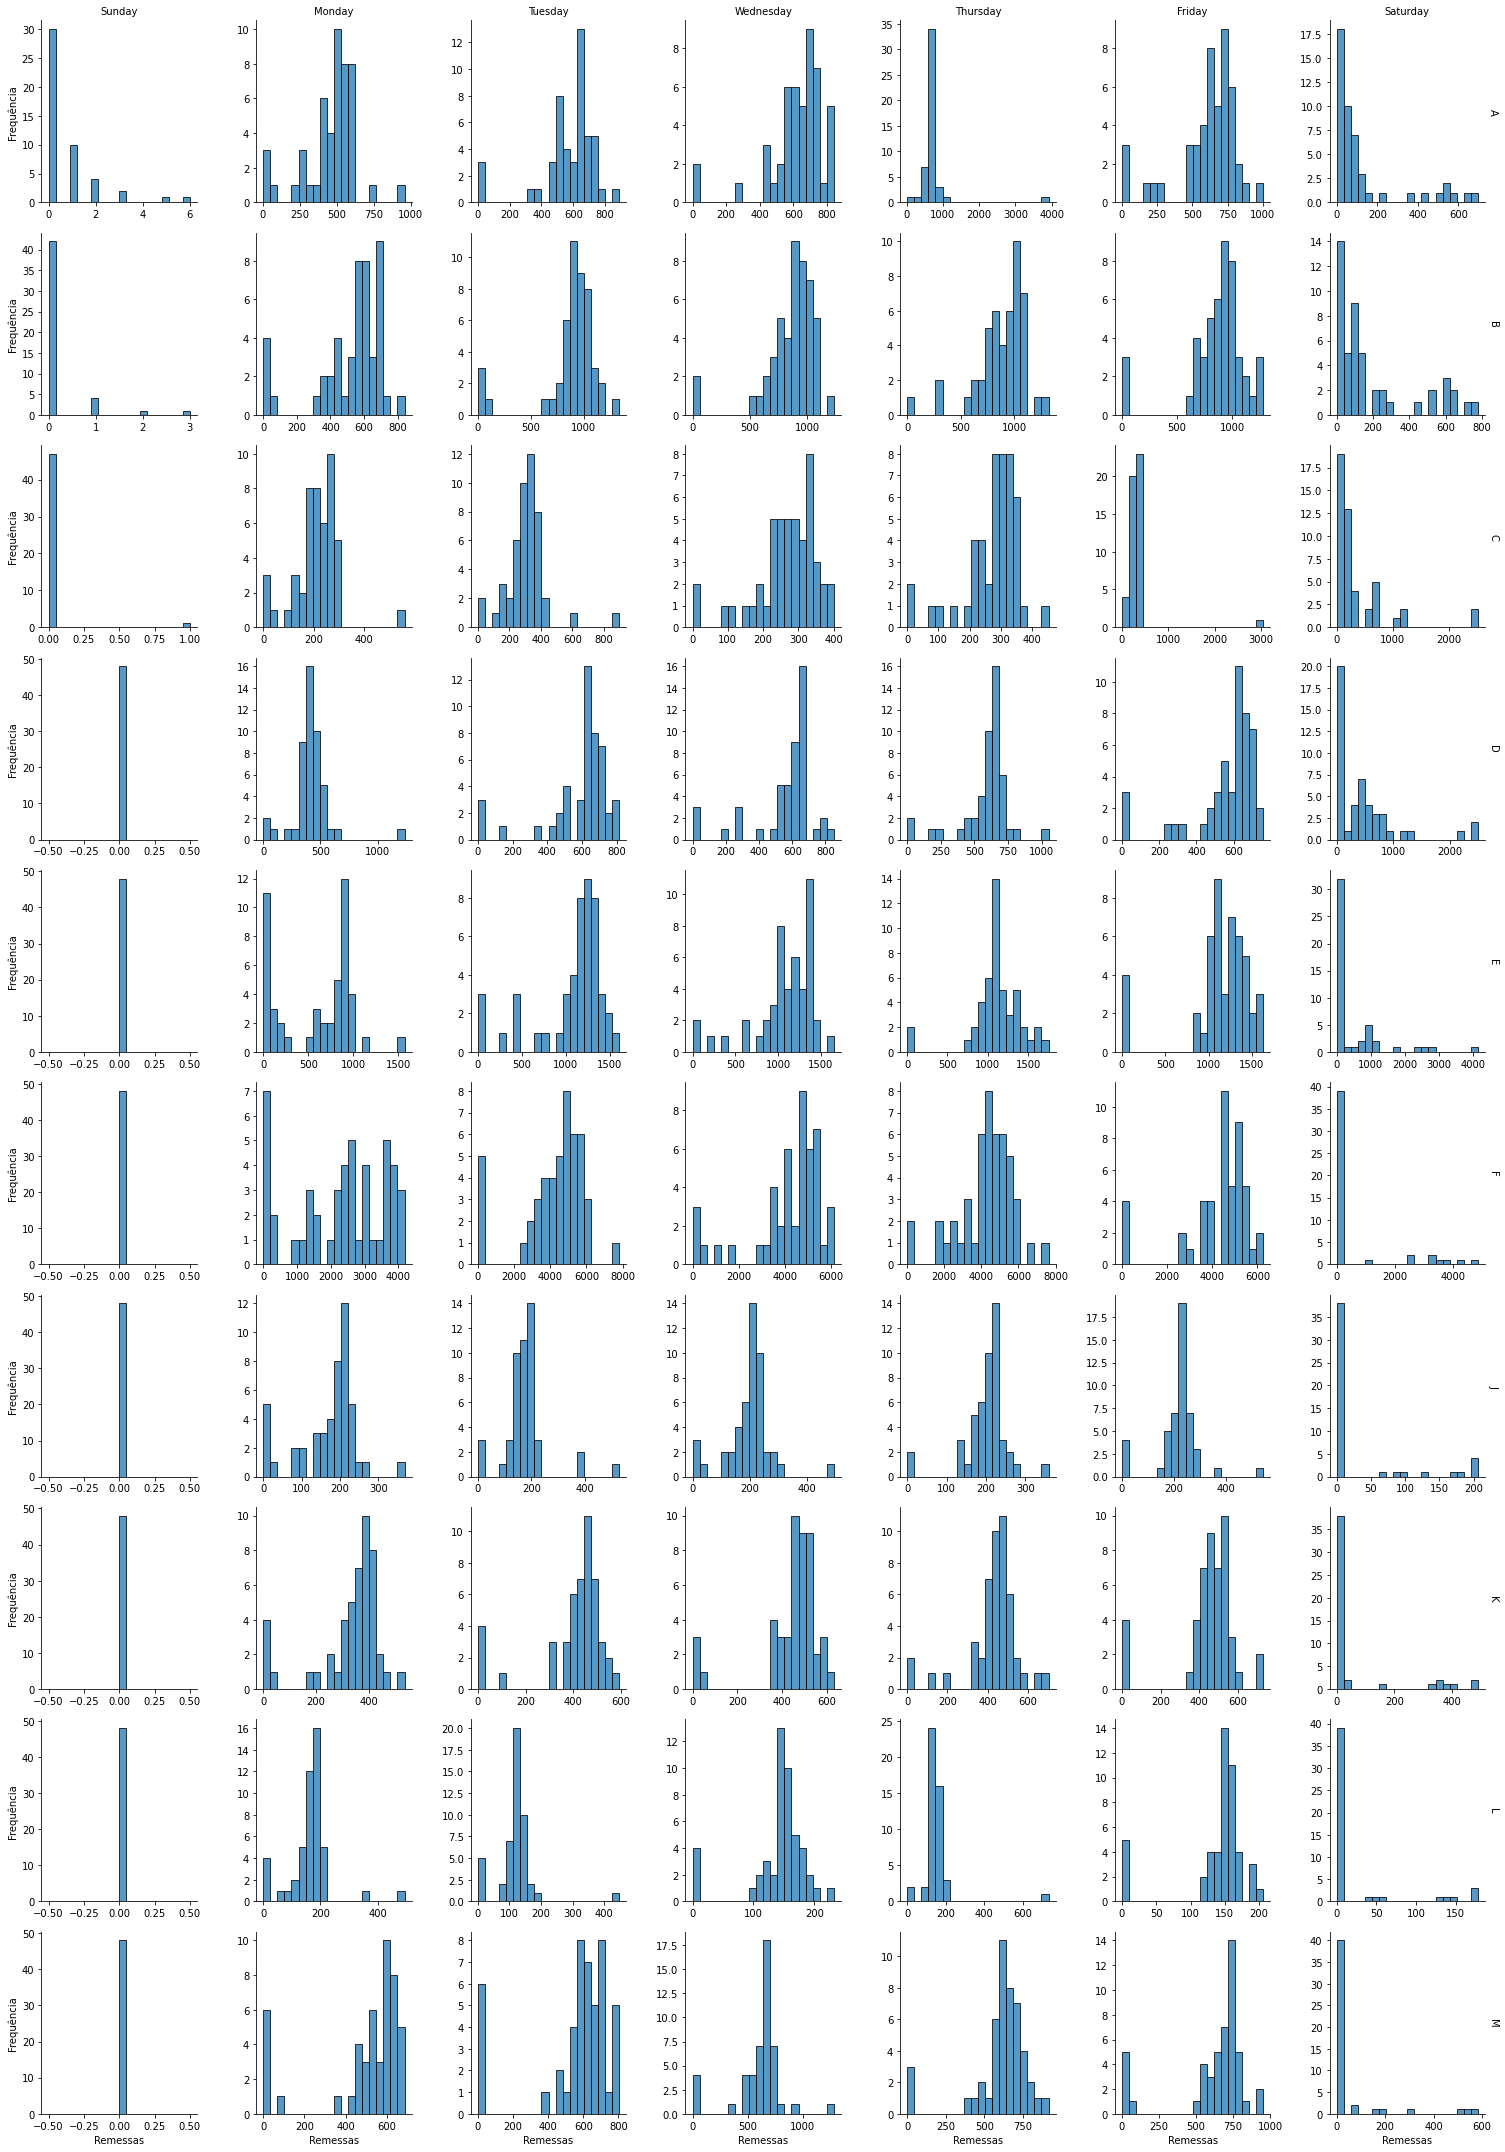

In [70]:
g = sns.FacetGrid(df, col="DiaNome", col_order=week_order,
                  row="Cluster", margin_titles=True,
                  sharex=False, sharey=False)
g.map_dataframe(sns.histplot, x="Remessas", bins=20)
g.set_axis_labels("Remessas", None)
g.tight_layout()
g.set_titles(col_template="{col_name}", row_template="{row_name}")
for (row_val, col_val), ax in g.axes_dict.items():
    ylabel = "Frequência" if col_val == "Sunday" else None
    ax.set_ylabel(ylabel)
plt.show()

Adicionalmente, as maiores diferanças são observadas quando comparados dias de semana com os finais de semana. Isto está de acordo com o que observamos anteriormente quando analisamos a distribuição dos dados segundo segmentação de dia comercial (ou não).

Em dias que não são comerciais, o padrão para praticamente todos os cluster é não haver remessas. Apenas no caso dos Clusters A, B, C e D temos quantidade positiva de remessas no terceiro quartil da distribuição. Porém, ainda assim, parece ser mais a excessão que a regra.

In [25]:
df.loc[~df["DiaComercial"], "Remessas"].groupby(df["Cluster"]).describe().round(2).T

Cluster,A,B,C,D,E,F,J,K,L,M
count,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.0
mean,61.69,91.32,176.42,212.93,226.76,285.10,15.12,30.08,10.67,23.8
std,147.44,183.89,419.15,468.78,660.76,963.83,48.72,104.31,37.93,99.9
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
50%,2.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
75%,42.75,86.50,163.00,261.25,0.00,0.00,0.00,0.00,0.00,0.0
max,696.00,778.00,2525.00,2491.00,4141.00,4838.00,206.00,489.00,178.00,583.0


Considerando a distribuição por cluster para apenas os dias comerciais, vemos que em alguns casos a distribuição assemelha-se à normal (A, K, L, M). Apesar disso, em todos os clusters temos alguma assimetria nos dados.

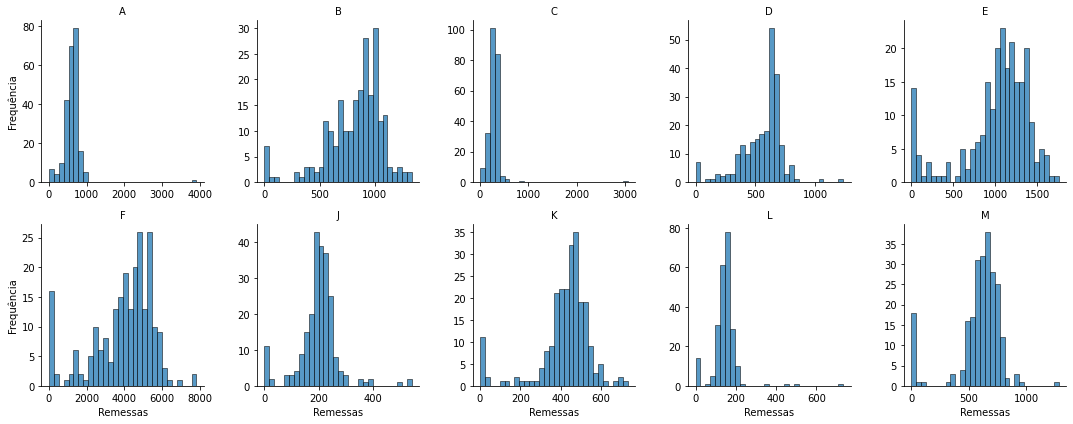

In [26]:
g = sns.FacetGrid(df.loc[df["DiaComercial"]],
                  col="Cluster", margin_titles=True,
                  sharex=False, sharey=False, col_wrap=5)
g.map_dataframe(sns.histplot, x="Remessas", bins=30)
g.set_axis_labels("Remessas", None)
g.tight_layout()
g.set_titles(col_template="{col_name}")
for col_val, ax in g.axes_dict.items():
    ylabel = "Frequência" if col_val in ["A", "F"] else None
    ax.set_ylabel(ylabel)
plt.show()

# Análise da Série Temporal

In [86]:
cluster_ts = df.pivot(index="DataEntrega", columns="Cluster", values="Remessas")
cluster_ts.head()

Cluster,A,B,C,D,E,F,J,K,L,M
DataEntrega,,,,,,,,,,
2019-10-01,466,5,898,159,441,116,529,0,0,0
2019-10-02,496,847,103,196,391,119,494,0,0,0
2019-10-03,574,571,192,219,1059,2380,218,386,122,493
2019-10-04,476,641,211,303,1174,3977,186,386,131,503
2019-10-05,11,51,102,0,0,0,0,0,0,0


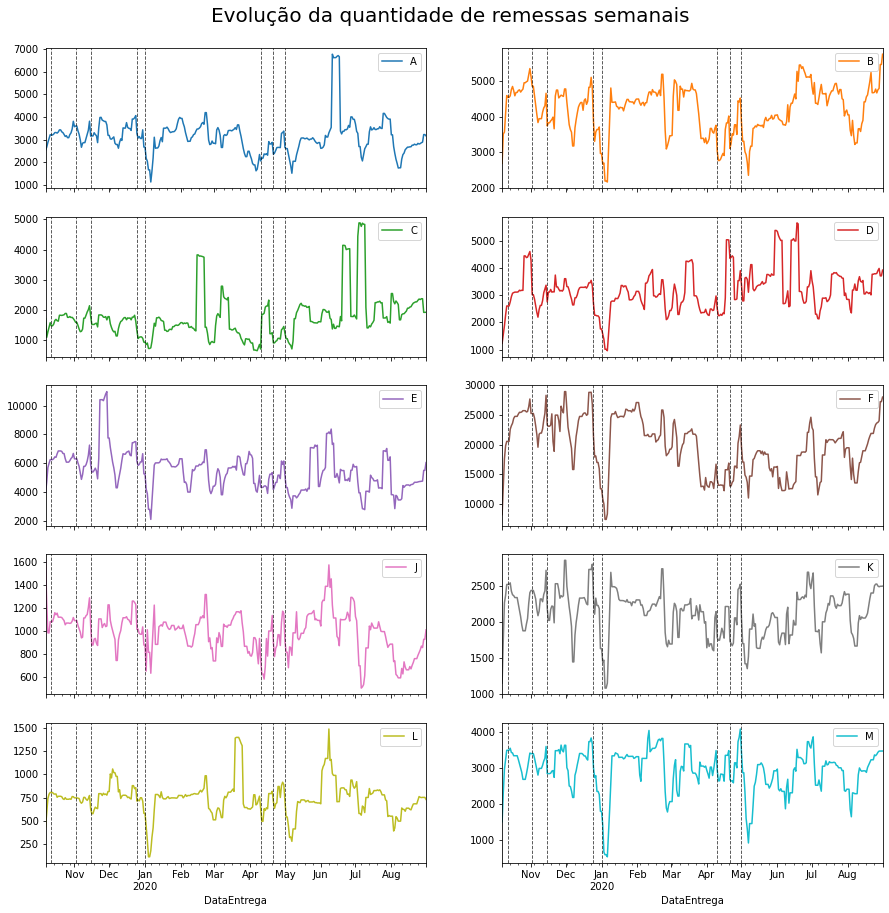

In [90]:
axs = (cluster_ts.
       rolling(window=7).sum().dropna().
       plot(subplots=True,
            figsize=(15, 15),
            layout=(5,2)))

for ax_line in axs:
    for ax in ax_line:
        for day in holiday_list:
            ax.axvline(day, color="black", linestyle="--", linewidth=0.9, alpha=0.7)

plt.suptitle("Evolução da quantidade de remessas semanais",
             y=0.9,
             fontsize=20,
             verticalalignment="bottom")
plt.show()

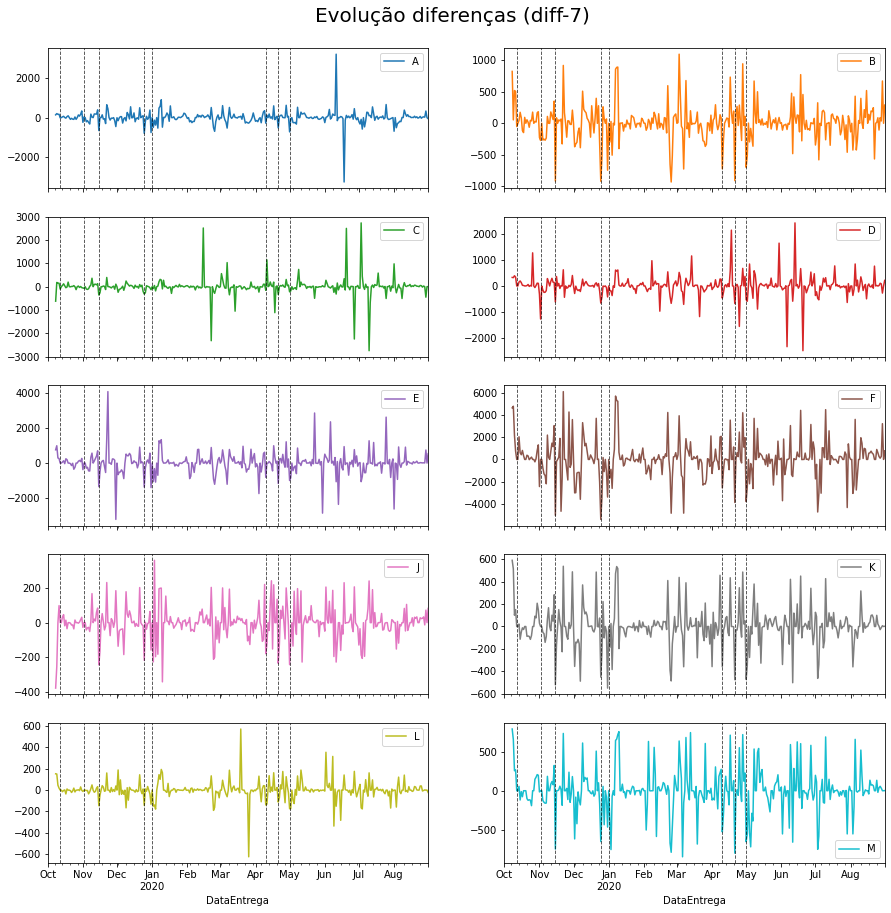

In [91]:
axs = (cluster_ts.diff(7).
       plot(subplots=True,
            figsize=(15, 15),
            layout=(5,2)))
for ax_line in axs:
    for ax in ax_line:
        for day in holiday_list:
            ax.axvline(day, color="black", linestyle="--", linewidth=0.9, alpha=0.7)

plt.suptitle("Evolução diferenças (diff-7)",
             y=0.9,
             fontsize=20,
             verticalalignment="bottom")
plt.show()

# Outliers

In [27]:
def match_outlier_normal(X: pd.Series, std_mul: float = 3.0) -> pd.Series:
    return X.abs() > X.mean() + std_mul * X.std()

In [64]:
def match_outlier_iqr_dist(X: pd.Series, iqr_mul: float = 5.0) -> pd.Series:
    q25 = X.quantile(q=0.25)
    q75 = X.quantile(q=0.75)
    iqr = q75 - q25
    return (X < q25 - iqr * iqr_mul) | (X > q75 + iqr * iqr_mul)

In [29]:
def get_weekly_mean_diffs(X: pd.Series):
    weekdays = X.index.weekday
    X_weekly_means = X.groupby(weekdays).transform("mean")
    return X.sub(X_weekly_means)

In [59]:
def plot_outlier_diagnostic(cluster_data: pd.Series, method: str = "iqr") -> None:
    
    cluster_weekly_mean_diff = get_weekly_mean_diffs(X=cluster_data)
    
    if method == "iqr":
        outlier_mask = match_outlier_iqr_dist(X=cluster_weekly_mean_diff)
    elif method == "normal":
        outlier_mask = match_outlier_normal(X=cluster_weekly_mean_diff)
    else:
        print(f"Método '{method}' não disponível.")
        return

    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15, 5),
                                   gridspec_kw={'height_ratios': [2, 1]},
                                   sharex=True)
    fig.subplots_adjust(wspace=0, hspace=0.1)
    ax1.plot(cluster_data, c="black")
    ax1.scatter(cluster_data[outlier_mask].index,
                cluster_data[outlier_mask],
                c="red")
    
    
    ax2.plot(cluster_weekly_mean_diff, c="black")
    ax2.fill_between(cluster_weekly_mean_diff.index, -500, 500, alpha=0.5, color="lightblue")
    ax2.axhline(0, c="gray", linestyle="--", linewidth=0.7)
    
    plt.show()

In [51]:
1.5 * cluster_time_series["D"].quantile(0.75) - cluster_time_series["D"].quantile(0.25)

798.375

In [62]:
cluster_time_series["D"].describe()

count     336.000000
mean      452.303571
std       335.631048
min         0.000000
25%       181.500000
50%       533.000000
75%       653.250000
max      2491.000000
Name: D, dtype: float64

In [69]:
plot_outlier_diagnostic(cluster_time_series["F"], method="iqr")

NameError: name 'plot_outlier_diagnostic' is not defined

In [104]:
cluster_time_series[cluster].quantile(q=0.75)

669.0

In [32]:
cluster = "M"
cluster_time_series[cluster].sub(cluster_time_series[cluster].groupby(cluster_time_series.index.weekday).transform("mean")).plot()
plt.plot()

NameError: name 'cluster_time_series' is not defined

<AxesSubplot:>

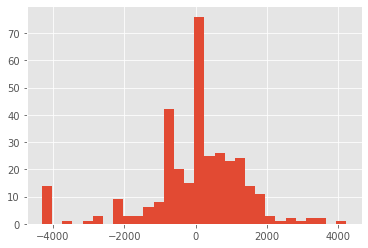

In [70]:
cluster_time_series[cluster].sub(cluster_time_series[cluster].groupby(cluster_time_series.index.weekday).transform("mean")).hist(bins=30)

# Conclusão

In [ ]:
# identificando outliers - 3sd
# identificando outliers - 1.5 IQR
# criando um dicionário onde para cada cluster quais são as datas outliers

In [23]:
df.to_csv("train.csv")